In [2932]:
import esda
import pandas as pd
from urllib.parse import quote
from ast import literal_eval
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import mapclassify as mc

%matplotlib inline

## Data Preparation

In [2933]:
#Read bikescore
df1 = pd.read_excel('bike_score.xlsx')
#read tract data for XY coordinates
df2 = pd.read_excel('Brooklyn_Tracts_SpatialSampling_XY.xlsx')
#Outer join two df
df_outer = pd.merge(df1, df2, on='Census Tract FIPS Code (2020)', how='outer')

In [2934]:
#Data cleaning
#Remove unneccessary columns
df_outer.drop(['OID', 'CID'], axis=1, inplace=True)
#rename column Census Tract FIPS Code (2020) to GEOID for join
df_outer.rename(columns={'Census Tract FIPS Code (2020)':'GEOID'},inplace=True)
df_outer

,GEOID,bike_score,description,detail,Latitude_X,Longitude_Y
0,36047000100,79.0,Very Bikeable,Biking is convenient for most trips.,-73.991623,40.701103
1,36047000100,79.0,Very Bikeable,Biking is convenient for most trips.,-73.996010,40.700958
2,36047000100,79.0,Very Bikeable,Biking is convenient for most trips.,-73.994453,40.702297
3,36047000100,79.0,Very Bikeable,Biking is convenient for most trips.,-73.993233,40.700279
4,36047000100,79.0,Very Bikeable,Biking is convenient for most trips.,-73.991226,40.700298
...,...,...,...,...,...,...
4057,36081056100,57.2,Bikeable,Some bike infrastructure.,-73.901703,40.690548
4058,36081056100,57.2,Bikeable,Some bike infrastructure.,-73.901245,40.688511
4059,36081056100,57.2,Bikeable,Some bike infrastructure.,-73.895149,40.684135
4060,36081064102,33.0,Somewhat Bikeable,Minimal bike infrastructure.,-73.868652,40.694885


In [2935]:
#Create geodataframe
geometry = [Point(xy) for xy in zip(df_outer.Latitude_X,df_outer.Longitude_Y)]
#Point(xy) creates geometric point object for each pair of Latitude_X and Longitude_Y
crs = "EPSG:4326"
#EPSG:4326 refers to WGS84 standard, commonly used for GPS coordinates (lat, lon)
bike_score_gdf = GeoDataFrame(df_outer, crs=crs, geometry=geometry)

In [2936]:
#read geojson file 
gdf= gpd.read_file('brooklyn_censustract.geojson')

In [2937]:
#change type to match 
gdf['GEOID'] = gdf['GEOID'].astype('int64')

In [2938]:
#mean bike score for both dfs grouping by GEOID - for the purpose of making sure gdf has bike_score_gdf's geo coordinates, only selecting out gdf if bike_score_gdf's coordinates are included. 
bike_score_gdf['bike_score'] = bike_score_gdf['bike_score'].astype('float32')
#convert data type to float
sj_gdf = gpd.sjoin(gdf,bike_score_gdf, how ='inner', predicate = 'intersects', lsuffix = 'left', rsuffix = 'right')
#common spatial predicates include intersects, contains, equals..etc) does not matter much for points whether to choose intersects or contains
#sjoin is spatial join for geopandas, joining the map with bikescore gdf(coordinates) through innerjoin. gdf gets columnname_left and bike_score_gdf gets columnname_right if they both have the same columnname.
mean_bike_score_gb = sj_gdf.groupby(['GEOID_left'])['bike_score'].mean()
#column grouped by gdf's mean bike score

In [2939]:
mean_bike_score_gb.index.name = 'GEOID'
#changed name to do join

In [2940]:
#join geoid to gdf - less columns than sj_gdf
gdf = gdf.join(mean_bike_score_gb, on='GEOID')
#clean data
gdf = gdf[gdf['BoroName'] == 'Brooklyn']
gdf = gdf.drop(columns=['CDTANAME','BoroCode','BoroCT2020','CDEligibil','CT2020','CTLabel','OBJECTID','CDTA2020','NTA2020','PUMA'])
gdf


,BoroName,NTAName,GEOID,Shape__Area,Shape__Length,geometry,bike_score
1167,Brooklyn,Brooklyn Heights,36047000100,2.224101e+06,6611.443960,"POLYGON ((-73.99093 40.70077, -73.99088 40.700...",79.000000
1168,Brooklyn,Brooklyn Heights,36047000301,2.164337e+06,6525.111338,"POLYGON ((-73.99429 40.69854, -73.99461 40.697...",74.166664
1169,Brooklyn,Brooklyn Heights,36047000501,9.015070e+05,4828.170276,"POLYGON ((-73.99302 40.69747, -73.99379 40.695...",89.199997
1170,Brooklyn,Brooklyn Heights,36047000502,1.041529e+06,4902.479685,"POLYGON ((-73.99137 40.69702, -73.99129 40.696...",90.599998
1171,Brooklyn,Brooklyn Heights,36047000700,1.881578e+06,6253.288481,"POLYGON ((-73.99672 40.69345, -73.99593 40.693...",83.199997
...,...,...,...,...,...,...,...
2307,Brooklyn,McGuire Fields,36047070602,1.058959e+07,24718.581258,"POLYGON ((-73.90419 40.61357, -73.90415 40.613...",50.599998
2308,Brooklyn,Downtown Brooklyn-DUMBO-Boerum Hill,36047001501,1.776388e+06,6693.033654,"POLYGON ((-73.98051 40.69745, -73.98041 40.696...",92.199997
2309,Brooklyn,Fort Greene,36047002901,1.167568e+06,4333.864021,"POLYGON ((-73.97644 40.69635, -73.97642 40.696...",92.199997
2312,Brooklyn,Brooklyn Heights,36047000900,1.769269e+06,5930.081969,"POLYGON ((-73.99067 40.69458, -73.99045 40.693...",91.400002


## Plots

color maps in matplotlib operates on normalized data 

In [2941]:
'''import matplotlib.cm as cm
import matplotlib.colors as mcolors
#bikescore plot
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

gdf.plot(column='bike_score', cmap='GnBu', edgecolor='black', linewidth=0.5, ax=ax)

min_value, max_value = gdf['bike_score'].min(), gdf['bike_score'].max()
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)
cmap = cm.ScalarMappable(norm=norm, cmap='GnBu')

cbar = fig.colorbar(cmap, ax=ax, fraction=0.04, pad=0.03)
cbar.set_label('Bike Score')

ax.set_title('Bike Scores in Brooklyn')
ax.set_xticks([])
ax.set_yticks([])

plt.show()'''

"import matplotlib.cm as cm\nimport matplotlib.colors as mcolors\n#bikescore plot\nfig, ax = plt.subplots(1, 1, figsize=(12, 12))\n\ngdf.plot(column='bike_score', cmap='GnBu', edgecolor='black', linewidth=0.5, ax=ax)\n\nmin_value, max_value = gdf['bike_score'].min(), gdf['bike_score'].max()\nnorm = mcolors.Normalize(vmin=min_value, vmax=max_value)\ncmap = cm.ScalarMappable(norm=norm, cmap='GnBu')\n\ncbar = fig.colorbar(cmap, ax=ax, fraction=0.04, pad=0.03)\ncbar.set_label('Bike Score')\n\nax.set_title('Bike Scores in Brooklyn')\nax.set_xticks([])\nax.set_yticks([])\n\nplt.show()"

Quantile plotting highlights patters and handles skewed data better, also easier to interpret and compare groups.

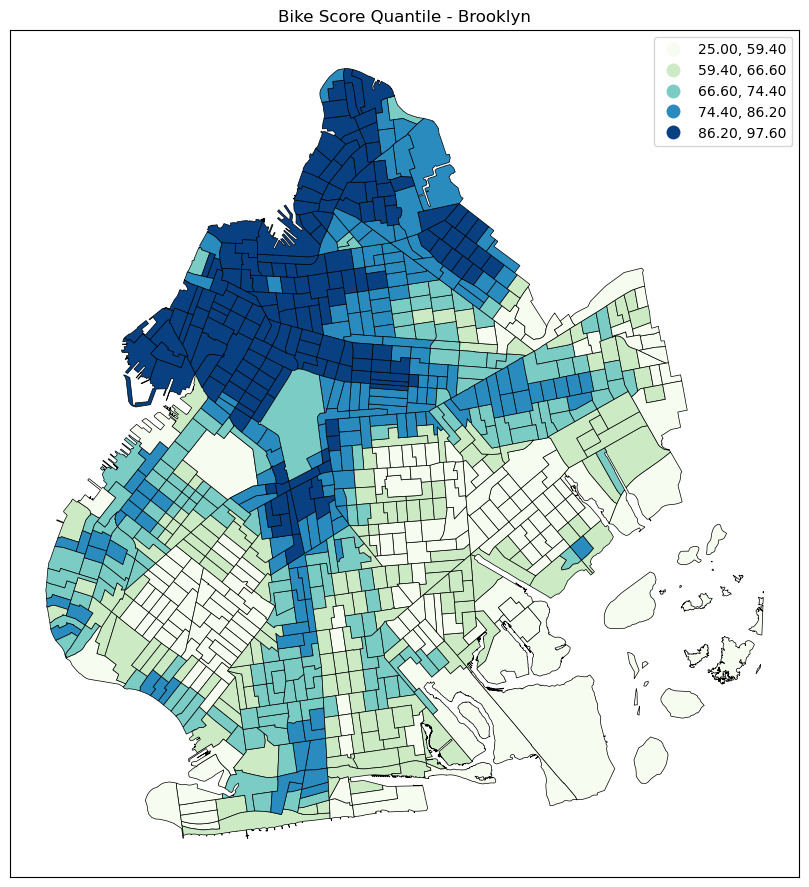

In [2942]:
#bike score plot based on quantiles 
fig, ax = plt.subplots(figsize=(11,11), subplot_kw={'aspect':'equal'})
gdf.plot(column='bike_score', scheme='Quantiles', k=5, cmap='GnBu', edgecolor='black', legend=True, linewidth=0.5, ax=ax)
ax.set_title('Bike Score Quantile - Brooklyn')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Spatial Autocorrelation


In [2943]:
#Define spatial weights

df = gdf[gdf['bike_score']>0]
wq = lps.weights.Queen.from_dataframe(df) # automatically detects geometry column
#Queen contiguity considers two polygons as neighbors if they share eiter a vertex or an edge.(chess queen) - define spatial weights based on the adjacency of polygons
k=13
wq2 = lps.weights.KNN.from_dataframe(df,k=k)
wq.transform = 'r'
wq2.transform = 'r'

('WARNING: ', 523, ' is an island (no neighbors)')


c:\temp\ipykernel_31864\2557278405.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df) # automatically detects geometry column
c:\Users\ChoJ2\AppData\Local\anaconda3\envs\gds\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 523.
  W.__init__(self, neighbors, ids=ids, **kw)


Spatial weights are important for clustering similar values and dispersion. It removes false positives ans subjective bias

Here, spatial autocorrelation considers two factors spatial similarity(based on adjacency) and attribute similarity(Spatial lag)

Measures of Spatial autocorrelation at global level - Moran's I local - Local Moran's I or Getis-Ord G*(hotspot)

In [2944]:
df

,BoroName,NTAName,GEOID,Shape__Area,Shape__Length,geometry,bike_score
1167,Brooklyn,Brooklyn Heights,36047000100,2.224101e+06,6611.443960,"POLYGON ((-73.99093 40.70077, -73.99088 40.700...",79.000000
1168,Brooklyn,Brooklyn Heights,36047000301,2.164337e+06,6525.111338,"POLYGON ((-73.99429 40.69854, -73.99461 40.697...",74.166664
1169,Brooklyn,Brooklyn Heights,36047000501,9.015070e+05,4828.170276,"POLYGON ((-73.99302 40.69747, -73.99379 40.695...",89.199997
1170,Brooklyn,Brooklyn Heights,36047000502,1.041529e+06,4902.479685,"POLYGON ((-73.99137 40.69702, -73.99129 40.696...",90.599998
1171,Brooklyn,Brooklyn Heights,36047000700,1.881578e+06,6253.288481,"POLYGON ((-73.99672 40.69345, -73.99593 40.693...",83.199997
...,...,...,...,...,...,...,...
2307,Brooklyn,McGuire Fields,36047070602,1.058959e+07,24718.581258,"POLYGON ((-73.90419 40.61357, -73.90415 40.613...",50.599998
2308,Brooklyn,Downtown Brooklyn-DUMBO-Boerum Hill,36047001501,1.776388e+06,6693.033654,"POLYGON ((-73.98051 40.69745, -73.98041 40.696...",92.199997
2309,Brooklyn,Fort Greene,36047002901,1.167568e+06,4333.864021,"POLYGON ((-73.97644 40.69635, -73.97642 40.696...",92.199997
2312,Brooklyn,Brooklyn Heights,36047000900,1.769269e+06,5930.081969,"POLYGON ((-73.99067 40.69458, -73.99045 40.693...",91.400002


In [2945]:
#Spatial lag: for attribute similartiy - hot bike score values compare (weighted average for the neighbors of a given spatial unit)
y=df['bike_score']
ylag = lps.weights.lag_spatial(wq, y)
y2lag = lps.weights.lag_spatial(wq2, y)
ylagq5 = mc.Quantiles(ylag, k=5)
y2lagq5 = mc.Quantiles(y2lag, k=5)

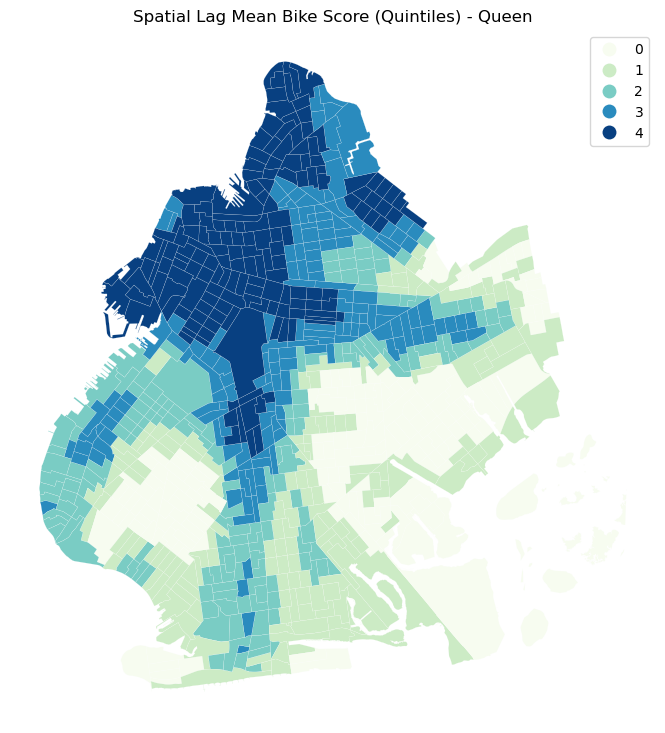

In [2946]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Mean Bike Score (Quintiles) - Queen")

plt.show()

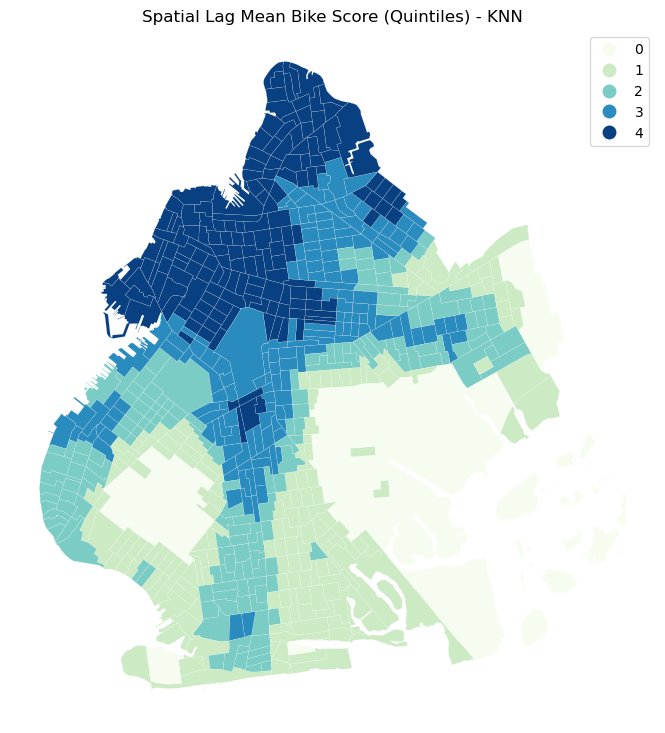

In [2947]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=y2lagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Mean Bike Score (Quintiles) - KNN")

plt.show()

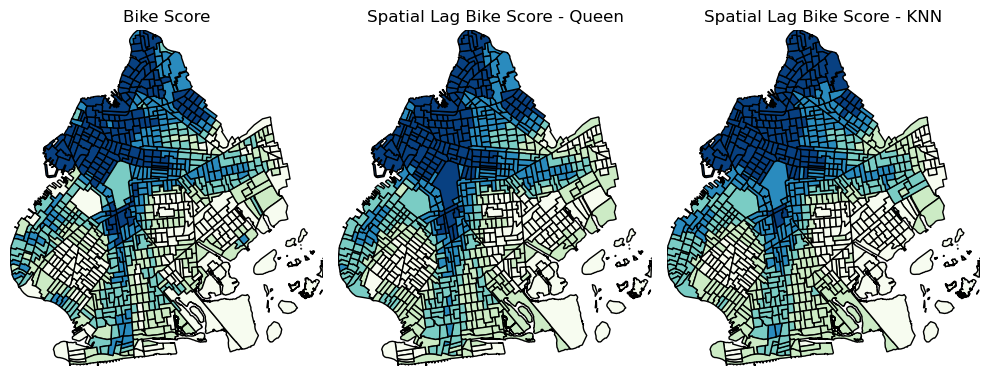

In [2948]:
df['lag_queen_bike_score'] = ylag
df['lag_knn_bike_score'] = y2lag
fig, axes = plt.subplots(1, 3, figsize=(10, 15))    

# Plot 1: Bike Score
df.plot(column='bike_score', ax=axes[0], edgecolor='k',
        scheme="quantiles", k=5, cmap='GnBu')
axes[0].axis(df.total_bounds[np.asarray([0, 2, 1, 3])])
axes[0].set_title("Bike Score")

# Plot 2: Spatial Lag Bike Score - Queen
df.plot(column='lag_queen_bike_score', ax=axes[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
axes[1].axis(df.total_bounds[np.asarray([0, 2, 1, 3])])
axes[1].set_title("Spatial Lag Bike Score - Queen")


# Plot 3: Spatial Lag Bike Score - KNN
df.plot(column='lag_knn_bike_score', ax=axes[2], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
axes[2].axis(df.total_bounds[np.asarray([0, 2, 1, 3])])
axes[2].set_title("Spatial Lag Bike Score - KNN")

# Remove axis ticks and labels for all subplots
for ax in axes:
    ax.axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [2949]:
df

,BoroName,NTAName,GEOID,Shape__Area,Shape__Length,geometry,bike_score,lag_queen_bike_score,lag_knn_bike_score
1167,Brooklyn,Brooklyn Heights,36047000100,2.224101e+06,6611.443960,"POLYGON ((-73.99093 40.70077, -73.99088 40.700...",79.000000,85.605641,88.848324
1168,Brooklyn,Brooklyn Heights,36047000301,2.164337e+06,6525.111338,"POLYGON ((-73.99429 40.69854, -73.99461 40.697...",74.166664,83.799998,90.553845
1169,Brooklyn,Brooklyn Heights,36047000501,9.015070e+05,4828.170276,"POLYGON ((-73.99302 40.69747, -73.99379 40.695...",89.199997,81.741665,88.525246
1170,Brooklyn,Brooklyn Heights,36047000502,1.041529e+06,4902.479685,"POLYGON ((-73.99137 40.69702, -73.99129 40.696...",90.599998,86.900000,88.889743
1171,Brooklyn,Brooklyn Heights,36047000700,1.881578e+06,6253.288481,"POLYGON ((-73.99672 40.69345, -73.99593 40.693...",83.199997,89.023808,90.520512
...,...,...,...,...,...,...,...,...,...
2307,Brooklyn,McGuire Fields,36047070602,1.058959e+07,24718.581258,"POLYGON ((-73.90419 40.61357, -73.90415 40.613...",50.599998,54.450001,58.176923
2308,Brooklyn,Downtown Brooklyn-DUMBO-Boerum Hill,36047001501,1.776388e+06,6693.033654,"POLYGON ((-73.98051 40.69745, -73.98041 40.696...",92.199997,91.142858,90.435503
2309,Brooklyn,Fort Greene,36047002901,1.167568e+06,4333.864021,"POLYGON ((-73.97644 40.69635, -73.97642 40.696...",92.199997,91.119998,92.046153
2312,Brooklyn,Brooklyn Heights,36047000900,1.769269e+06,5930.081969,"POLYGON ((-73.99067 40.69458, -73.99045 40.693...",91.400002,90.999999,90.166666


## Global Spatial Autocorrelation

We have 380 neighborhoods with bikescore above mean bikescore. Although the attribute is continously valued one, if converted to binary case it maps as below. Based on adjacent area three different types of joins would occur Black with Black, White with White, and Black with White. Using esda's join count analysis, we get the bell plot significantly low p-value (0.001) rejecting the null hypothesis CSR. The point of cahnging to binary is to identify that the spatial pattern is not random.

## Binary Case

In [2950]:
#y.mean()

In [2951]:
'''yb = y > y.mean()
sum(yb)'''

'yb = y > y.mean()\nsum(yb)'

In [2952]:
'''yb = y > y.mean()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb'''

'yb = y > y.mean()\nlabels = ["0 Low", "1 High"]\nyb = [labels[i] for i in 1*yb] \ndf[\'yb\'] = yb'

In [2953]:
'''fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)
plt.show()'''

"fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})\ndf.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)\nplt.show()"

In [2954]:
'''import esda
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)'''

"import esda\nyb = 1 * (y > y.median()) # convert back to binary\nwq =  lps.weights.Queen.from_dataframe(df)\nwq.transform = 'b'\nnp.random.seed(12345)\njc = esda.join_counts.Join_Counts(yb, wq)"

In [2955]:
#jc.bb

In [2956]:
#jc.ww

In [2957]:
#jc.bw

In [2958]:
'''import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')
plt.show()'''

"import seaborn as sbn\nsbn.kdeplot(jc.sim_bb, shade=True)\nplt.vlines(jc.bb, 0, 0.075, color='r')\nplt.vlines(jc.mean_bb, 0,0.075)\nplt.xlabel('BB Counts')\nplt.show()"

In [2959]:
#jc.p_sim_bb

## Continuous Case

In [2960]:
wq.transform = 'r' # row standardize the weights - each units weights sum to 1
y = df['bike_score']
np.random.seed(12345)
mi = esda.moran.Moran(y, wq) # calculate Moran's I
mi.I

0.8719489278979037

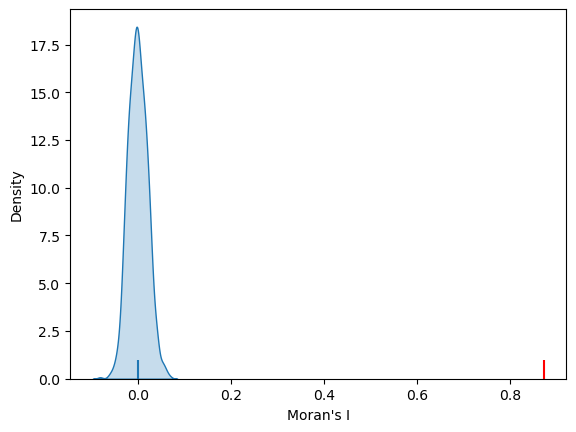

0.001

In [2961]:
import seaborn as sbn
sbn.kdeplot(mi.sim, fill=True)
plt.vlines(mi.I, 0, 1, color='r') # actual data
plt.vlines(mi.EI, 0,1) #expected
plt.xlabel("Moran's I")
plt.show()
mi.p_sim # p value

0.001 < 0.05 : reject the null hypothesis (there is significant spatial autocorrelation)

Now through global autocorrelation, we know there are correlation according to the spatial analysis. Through Local autocorrelation, we are to find the details.

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers


In [2962]:
np.random.seed(12345)


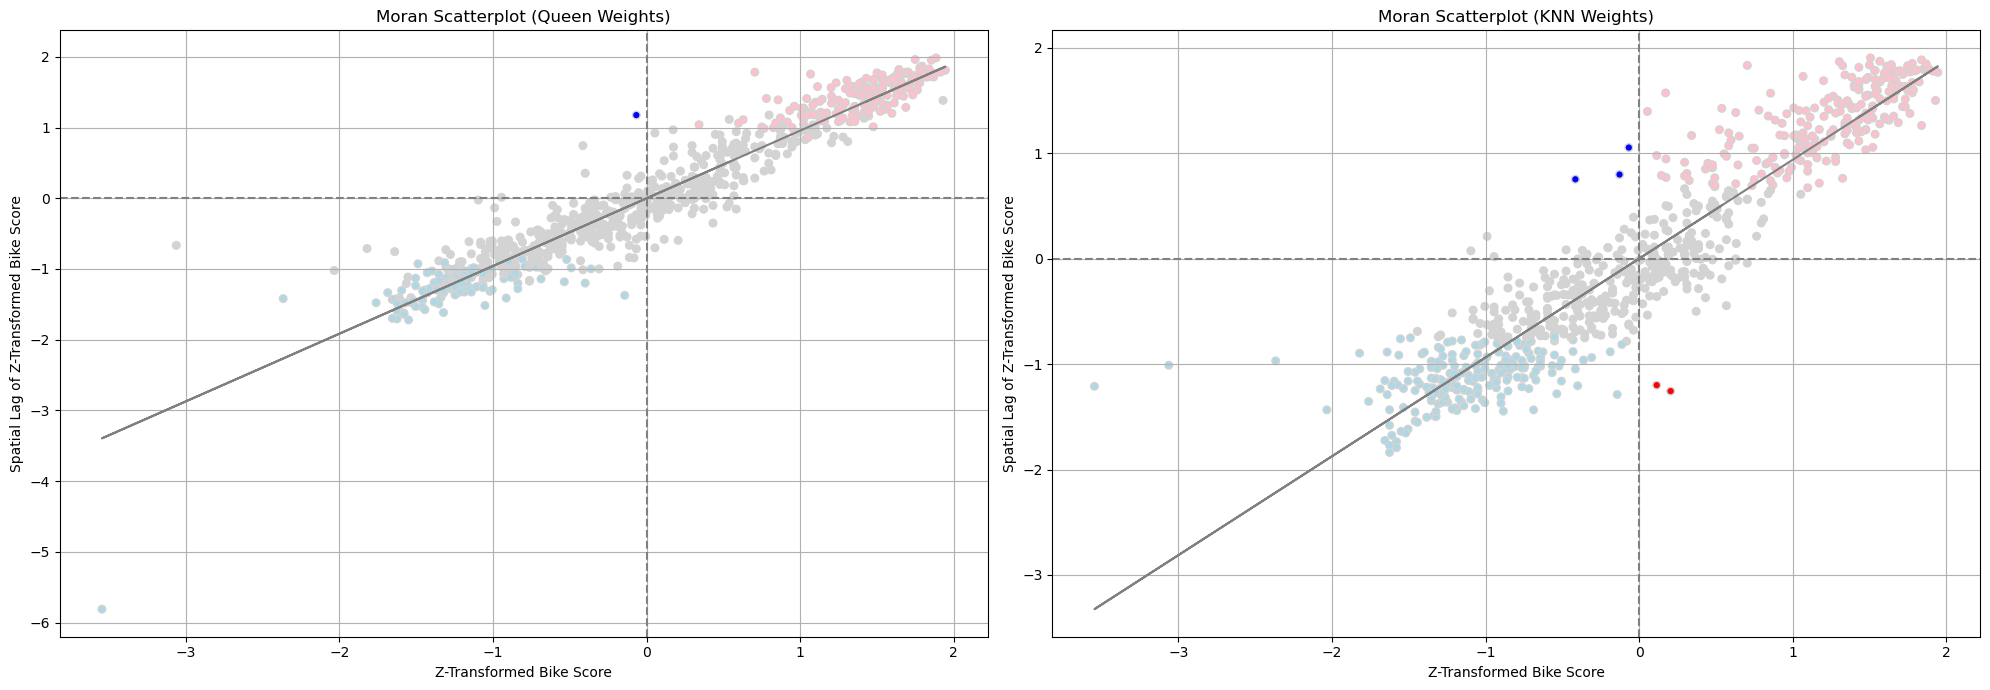

In [2963]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Z-transform variables
z_bikescore = (y - y.mean()) / y.std()
z_lag_queen_bikescore = (ylag - ylag.mean()) / ylag.std()
z_lag_knn_bikescore = (y2lag - y2lag.mean()) / y2lag.std()

# Categories: High-High, Low-High, Low-Low, High-Low
categories = {
    1: 'pink',        # High-High
    2: 'blue',        # Low-High
    3: 'lightblue',   # Low-Low
    4: 'red',         # High-Low
    0: 'lightgrey'    # Non-significant
}

# Create a 2x1 subplot layout with appropriate figsize
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Data for each Moran scatterplot
lag_data = [
    (z_bikescore, z_lag_queen_bikescore, li.q, li.p_sim, "Queen Weights"),
    (z_bikescore, z_lag_knn_bikescore, li2.q, li2.p_sim, "KNN Weights"),
]

# Loop over subplots and plot each Moran scatterplot
for ax, (x, y, q, p_sim, title) in zip(axes, lag_data):
    # Assign colors based on significance and quadrant
    colors = np.array([categories[q_val if p_val < 0.01 else 0] for q_val, p_val in zip(q, p_sim)])

    # Scatter plot
    ax.scatter(x, y, c=colors, edgecolor='lightgrey', s=30)

    # Dashed vertical and horizontal lines
    ax.axvline(0, linestyle='--', color='gray')
    ax.axhline(0, linestyle='--', color='gray')

    # Perform linear regression on Z-transformed variables
    b, a = np.polyfit(x, y, 1)

    # Best-fit line
    ax.plot(x, a + b * x, 'grey')

    # Add title, labels, and grid
    ax.set_title(f"Moran Scatterplot ({title})")
    ax.set_xlabel("Z-Transformed Bike Score")
    ax.set_ylabel("Spatial Lag of Z-Transformed Bike Score")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [2964]:
import esda
li = esda.moran.Moran_Local(z_bikescore, wq)
li2 = esda.moran.Moran_Local(z_bikescore, wq2)

c:\Users\ChoJ2\AppData\Local\anaconda3\envs\gds\Lib\site-packages\esda\moran.py:1084: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


In [2965]:
li.q

array([1, 1, 1, 1, 1, 1, 4, 1, 3, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 1, 4, 1, 2, 1, 1, 4, 1, 3, 4, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 3, 1, 3, 3, 3, 3, 3, 4, 4, 3, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3,
       1, 2, 1, 3, 1, 3, 1, 3, 3, 2, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3,
       1, 1, 1, 3, 1, 3, 1, 3, 3, 4, 2, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 4,
       1, 3, 1, 3, 1, 1, 4, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 2, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 2, 1, 3, 3, 1, 3, 1, 1, 3, 3, 4,

In [2966]:
(li.p_sim < 0.01).sum()

313

In [2967]:
(li2.p_sim < 0.01).sum()

462

In [2968]:
sig = li.p_sim < 0.01
hotspot = sig * li.q==1
coldspot = sig * li.q==3
low_high_outlier = sig * li.q==2
high_low_outlier = sig * li.q==4

In [2969]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

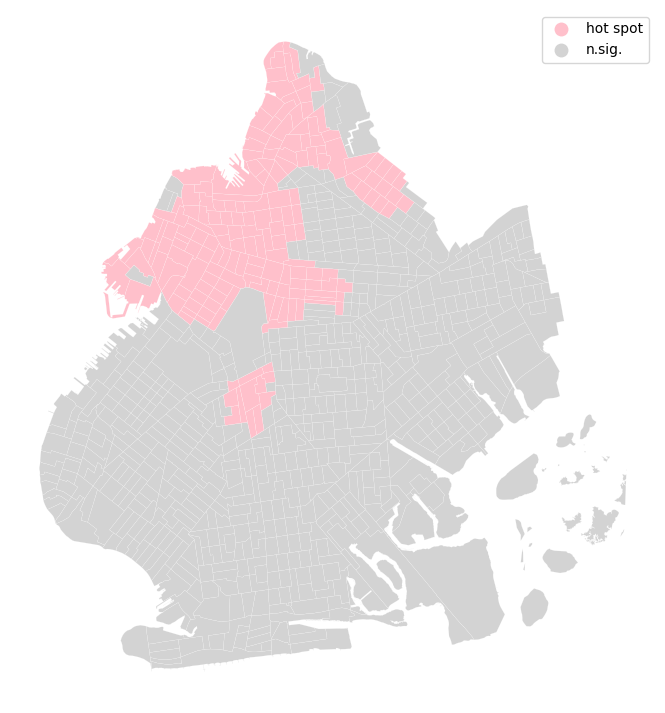

In [2970]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [2971]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

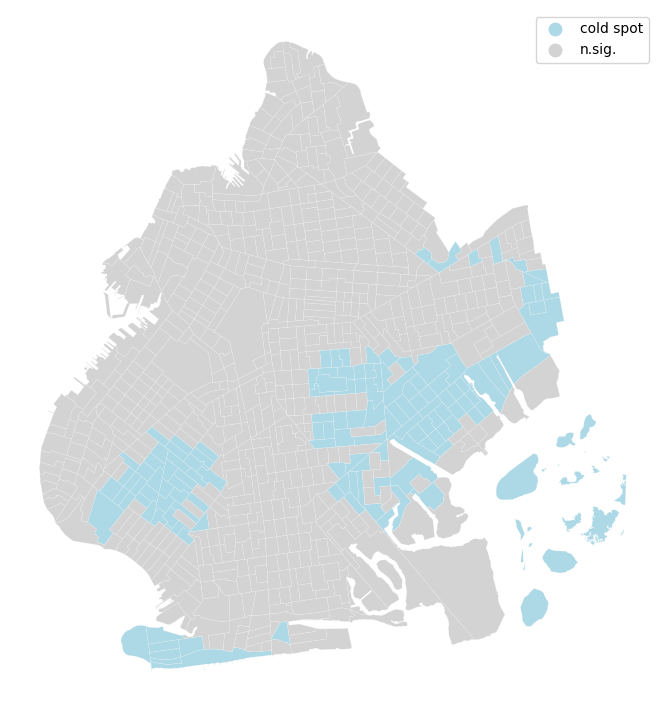

In [2972]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

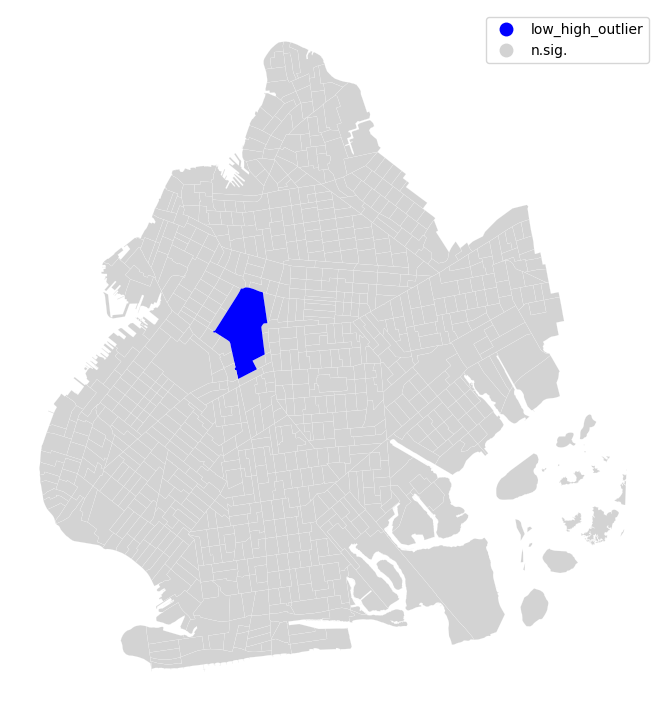

In [2973]:
spots = ['n.sig.', 'low_high_outlier']
labels = [spots[i] for i in low_high_outlier*1]
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [2974]:
spots = ['n.sig.', 'high_low_outlier']
labels = [spots[i] for i in high_low_outlier*1]

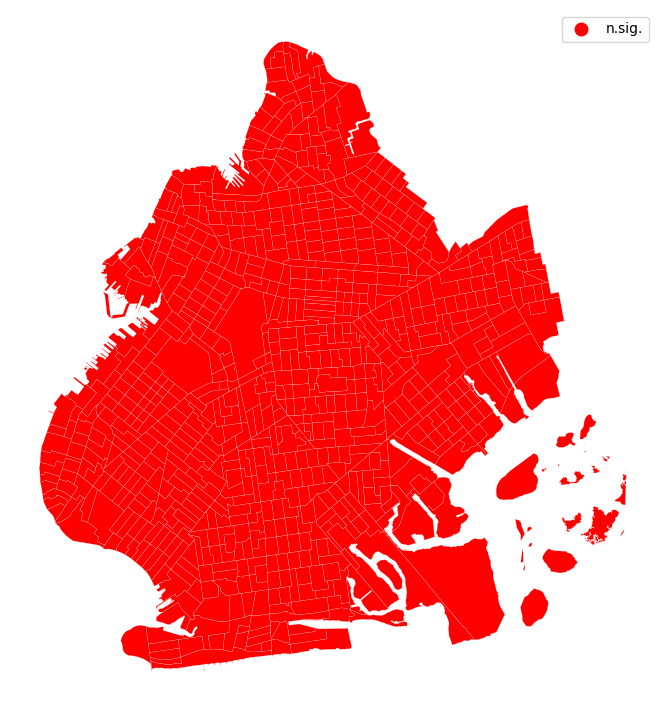

In [2975]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [2976]:
sig = 1 * (li.p_sim < 0.01)
hotspot = 1 * (sig * li.q==1) # high - high
coldspot = 3 * (sig * li.q==3) # low - low
low_high_outlier = 2 * (sig * li.q==2) # low - high (low values surrounded by high neighbors)
high_low_outlier = 4 * (sig * li.q==4) # high - low (high values surrounded by low neighbors)
spots = hotspot + coldspot + low_high_outlier + high_low_outlier
spots

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 3, 1, 0, 3, 1, 0, 1, 3, 1, 1, 1, 0,
       1, 1, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 3, 1, 0, 1, 3, 1,
       3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 0, 1, 3, 0, 1,
       0, 1, 0, 1, 3, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 3, 3, 1, 3, 1, 3, 0, 0, 1, 3, 0, 3, 1, 3, 1, 0, 1, 3, 0, 0, 0,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 3,
       0, 0, 0, 3, 1, 1, 1, 3, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [2977]:
spot_labels = [ '0 ns', '1 hot spot', '2 low-high outlier', '3 cold spot', '4 high-low outlier']
labels = [spot_labels[i] for i in spots]

## Final Plots

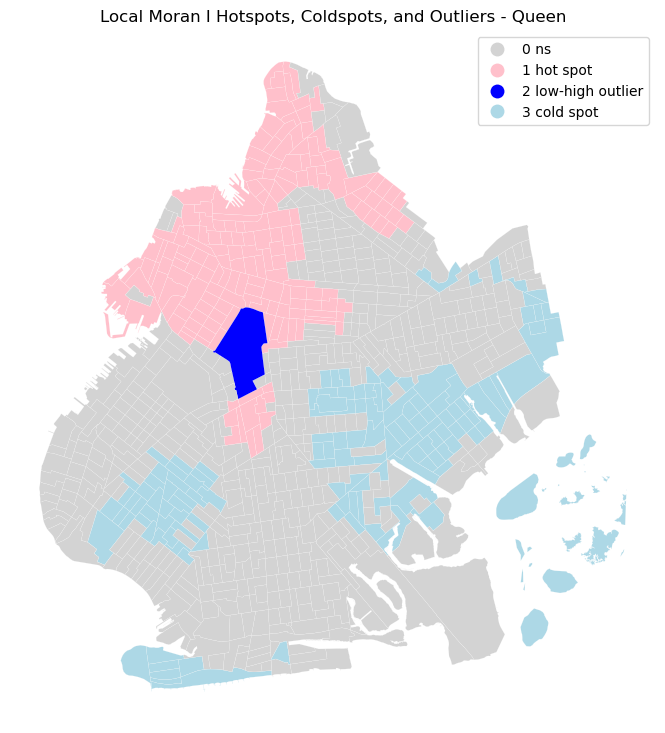

In [2978]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'pink', 'red', 'blue', 'lightblue'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Local Moran I Hotspots, Coldspots, and Outliers - Queen')
plt.show()

In [2979]:
sig = li2.p_sim < 0.01
hotspot = sig * li2.q==1
coldspot = sig * li2.q==3
low_high_outlier = sig * li2.q==2
high_low_outlier = sig * li2.q==4

sig = 1 * (li2.p_sim < 0.01)
hotspot = 1 * (sig * li2.q==1) # high - high
coldspot = 3 * (sig * li2.q==3) # low - low
low_high_outlier = 2 * (sig * li2.q==2) # low - high (low values surrounded by high neighbors)
high_low_outlier = 4 * (sig * li2.q==4) # high - low (high values surrounded by low neighbors)
spots = hotspot + coldspot + low_high_outlier + high_low_outlier

spot_labels = [ '0 ns', '1 hot spot', '2 low-high outlier', '3 cold spot', '4 high-low outlier']
labels = [spot_labels[i] for i in spots]

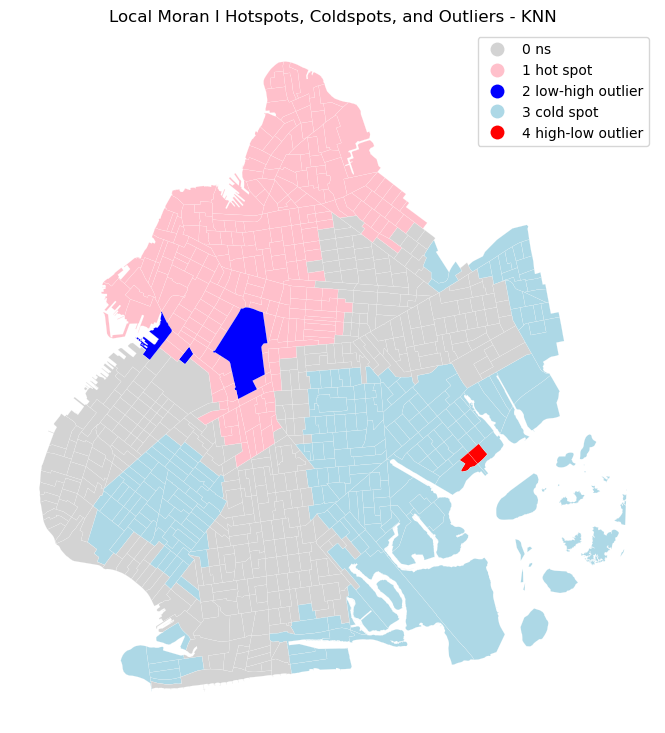

In [2980]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'pink', 'blue', 'lightblue', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Local Moran I Hotspots, Coldspots, and Outliers - KNN')
plt.show()

2,4 would be the oulier in Local Moran's I

## Getis-Ord G*

In [2981]:
y =df['bike_score']
np.random.seed(12345)
wq.transform = 'r'

In [2982]:
from esda.getisord import G_Local
g = G_Local(y,wq)
sig95 = g.p_sim < 0.05
sig99 = g.p_sim < 0.01
sig90 = g.p_sim <0.1

c:\Users\ChoJ2\AppData\Local\anaconda3\envs\gds\Lib\site-packages\esda\getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
c:\Users\ChoJ2\AppData\Local\anaconda3\envs\gds\Lib\site-packages\esda\getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


In [2983]:
hotspot95 = sig95 * (g.Zs > 0)  
coldspot95 = sig95 * (g.Zs < 0)  
hotspot90 = sig90 * (g.Zs > 0)  
coldspot90 = sig90 * (g.Zs < 0)  
hotspot99 = sig99 * (g.Zs > 0)  
coldspot99 = sig99 * (g.Zs < 0)  

In [2984]:
labels = ['Not Significant'] * len(df)


for i in range(len(df)):
    if hotspot99[i]:
        labels[i] = 'Hotspot 99%'
    elif coldspot99[i]:
        labels[i] = 'Coldspot 99%'
    elif hotspot95[i]:
        labels[i] = 'Hotspot 95%'
    elif coldspot95[i]:
        labels[i] = 'Coldspot 95%'
    elif hotspot90[i]:
        labels[i] = 'Hotspot 90%'
    elif coldspot90[i]:
        labels[i] = 'Coldspot 90%'

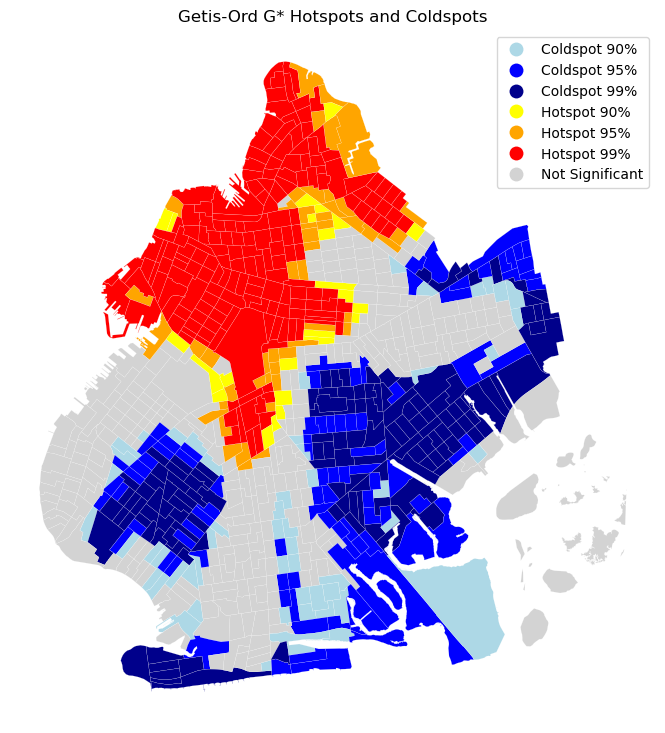

In [2986]:
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'blue', 'darkblue', 'yellow', 'orange', 'red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title('Getis-Ord G* Hotspots and Coldspots')
plt.show()